# Local Hartree Calculations in Rhombohedral

## Presets

In [291]:
using Optics_in_the_length_gauge
using PhysicalConstants, LinearAlgebra
using PhysicalConstants.CODATA2018
using Unitful
using Statistics
using Roots
const kB = (PhysicalConstants.CODATA2018.k_B |> u"eV/K").val
# add https://github.com/fernandopenaranda/Optics_in_the_length_gauge
# units meV, fs, K

proj_folder = dirname(pwd())
rhomb_folder = proj_folder * "/model/rhombohedral/"
common_folder = proj_folder * "/comfunctions/"
figures_folder = proj_folder * "/Paper/Figures/"

include(rhomb_folder * "model.jl")
include(rhomb_folder * "observables.jl")
include(rhomb_folder * "plotters.jl")
include(rhomb_folder * "filling.jl")
include(rhomb_folder * "wrapper_lmc.jl")
include(rhomb_folder * "spontaneous_sym_breakingmodels.jl")
include(rhomb_folder * "local_hartree_optimization.jl")
include(common_folder * "separate_contributions.jl")

plotmap! (generic function with 1 method)

In [221]:
μlist = collect(0:0.01:10)
p = Params_rhombohedral(1, 0, 3160, 390,-20, 315, 44, 2, 0)
T = 2
B = 10
evals = 10000
N = 7
T = 2 #evals 80000 not perfect
τ = 200
η = 0.05

0.05

In [3]:
lmc_presets(N, μ,ξ, p::Params_rhombohedral; kws...) =  xxx_lmc_presets(N, μ, ξ, p; kws...)
lmcnoshift_presets(μ,ξ, evals) = xxx_lmc_presets(N, μ, ξ, p; evals = evals, T = T, berry_contribution = true, omm_contribution = true, fermi_surface = false, with_shift = false)
lmcshift_presets(μ,ξ) = xxx_lmc_presets(N, μ, ξ, p; evals = evals, T = T, fermi_surface = false, with_shift = true)

sigmaijkpresets = lmc_presets(5, 0,1, p);

## Calculations

### Create the interpolated quantities as a function of Ez

In [222]:
include(rhomb_folder * "local_hartree_optimization.jl")
estimated_bound_width = 10
evals = 50000 # 1e5
η = 0.05 # 0.05
Ezlist = -6:0.1:6
# compute the interpolated functions passed to the optimization for each Ez in Ezlist
ϵ_mat, int_dos_mat, int_n_mat = interpolated_dos_ns_Ez(N, p, Ezlist, 
    estimated_bound_width = estimated_bound_width, evals = evals, η = η);

In [223]:
using JLD2
@save proj_folder * "/Paper/DATA/Interpolated_functions/N$(N)evals$(evals)eta$(η).jld" ϵ_mat int_dos_mat int_n_mat

In [53]:
# @load proj_folder * "/Paper/DATA/Interpolated_functions/N$(N)evals$(evals)eta$(η).jld" ϵ_mat int_dos_mat int_n_mat

3-element Vector{Symbol}:
 :ϵ_mat
 :int_dos_mat
 :int_n_mat

In [295]:
using JLD2
# @load "/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/DATA/Interpolated_functions/N7evals100000.0eta0.05.jld" ϵ_mat int_dos_mat int_n_mat
@load "/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/DATA/Interpolated_functions/N7evals50000eta0.05.jld" ϵ_mat int_dos_mat int_n_mat

3-element Vector{Symbol}:
 :ϵ_mat
 :int_dos_mat
 :int_n_mat

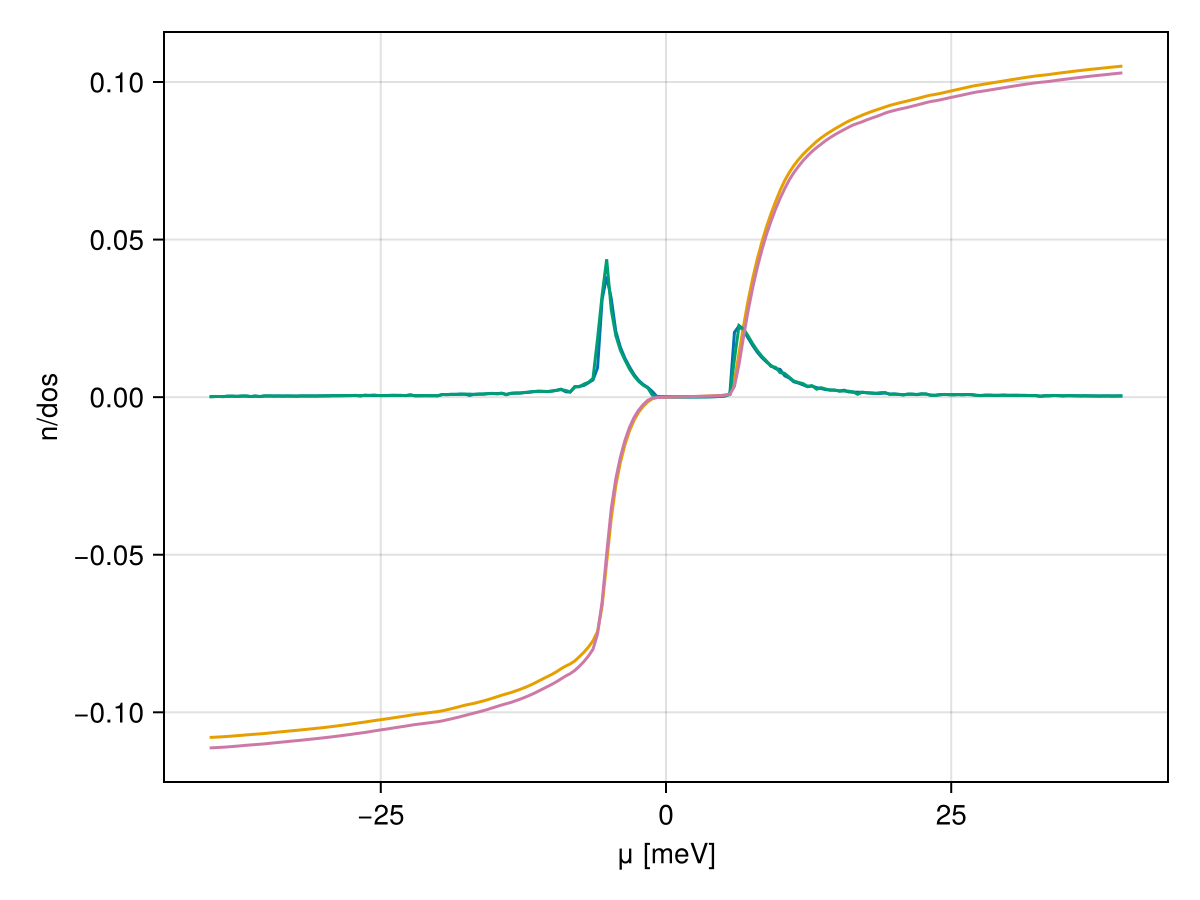

In [297]:
fig = Figure(); ax = Axis(fig[1,1], xlabel = "μ [meV]", ylabel = "n/dos")
# lines!(ax, ϵ_range, n.(ϵ_range))
for i in length(ϵ_mat)-1:length(ϵ_mat)
     lines!(ax, collect(ϵ_mat[i]), int_dos_mat[i].(collect(ϵ_mat[i])))
     lines!(ax, collect(ϵ_mat[i]), int_n_mat[i].(collect(ϵ_mat[i])))
end
fig

### Compute the occupations as a function of Ez

In [ ]:
include(rhomb_folder * "local_hartree_optimization.jl")

function plot_characters(N, U, J, Ezlist, νlist, ns)
    characters = character(ns)
    xvect = νlist
    fig = Figure()
    ax= Axis(fig[1,1], xlabel = "Ez [meV]", ylabel = "ν", title = "Character: N = $(N), U = $(U), J = $(J)")

    scatter!(ax, [100], [100], color = :gray, label = "Symmetric", marker = :rect, markersize = 20)
    scatter!(ax, [100], [100], color = :blue, label = "Half Metal SP", marker = :rect, markersize = 20)
    scatter!(ax, [100], [100], color = :purple, label = "Half Metal VP", marker = :rect, markersize = 20)
    scatter!(ax, [100], [100], color = :lightblue, label = "Quarter Metal/Insulator", marker = :rect, markersize = 20)
    ylims!(ax, xvect[1], xvect[end])
    xlims!(ax, Ezlist[1], Ezlist[end])
    axislegend(ax, position = :rc)
    levels = [-1, 0, 1, 2]
    colors = [:purple, :gray, :blue, :lightblue]
    hm =  heatmap!(ax, Ezlist,  xvect, characters, colormap = colors, levels = levels, colorrange = [-1,2])#, rasterize = true)
    return fig
end


In [308]:
include(rhomb_folder * "local_hartree_optimization.jl")
U = 20#+ 12
J = 0#- 4
νlist = collect(-0.1:0.025:0.1)
Ezsteps = 5
@time μs, ns = Emin_nαs(int_dos_mat, int_n_mat, νlist; steps = Ezsteps, random_guesses = 20,
    U = U, J = J, λ = 1e5, η = 0.05, estimated_bound_width = 20, iterations = 10, int_model = :SU2);

  2.543904 seconds (22.26 M allocations: 1.411 GiB, 8.73% gc time, 46.24% compilation time)


In [312]:
maximum(μs)

9-element Vector{Any}:
 [0.001476473852103349, 0.0014764738521154826, 0.001476473852110367, -0.006464753937230635]
 [0.001107354599402819, 0.0011073546000238028, -0.004848563568538774, 0.001107354599644437]
 [0.0007375274074324378, 0.000737527419811207, 0.0007375274174628204, -0.0032306833420301536]
 [0.000368912600572986, 0.00036891259974683807, 0.00036891259739884577, -0.0016156970807328975]
 [1.8420115194182513e-7, 1.8420115194182513e-7, 1.8420115194182805e-7, 1.8420115194182842e-7]
 [0.00019288794503689706, 0.00019292815692114546, 0.00019290567420727846, 0.00019291174672816447]
 [0.00038581712014555556, 0.0003858171225759073, 0.00038581712052821555, 0.00038581712118287195]
 [0.0005787256812851139, 0.000578725681091697, 0.0005787256811923548, 0.0005787256810526567]
 [0.0007716342417471761, 0.0007716342416433216, 0.0007716342414131779, 0.0007716342414451515]

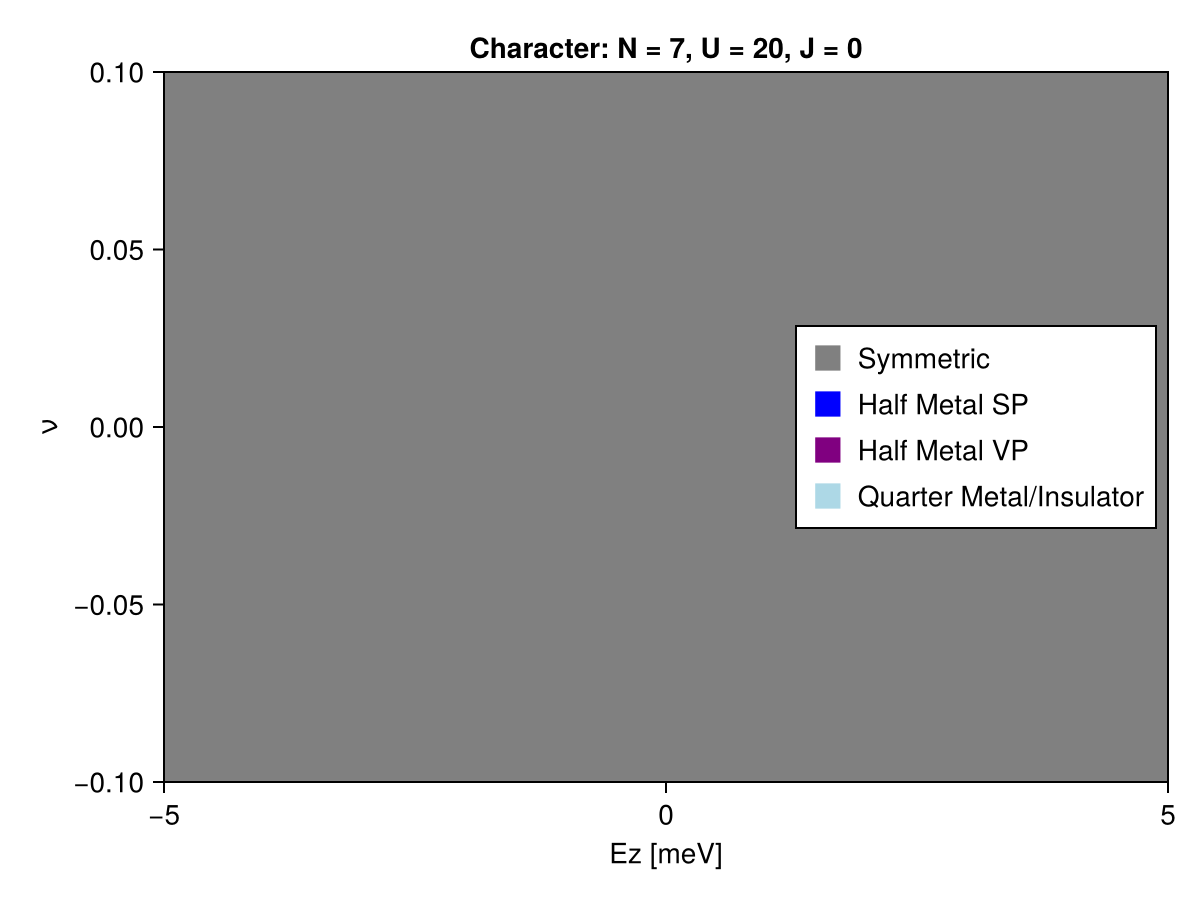

In [309]:
plot_characters(N, U, J, Ezlist, νlist, ns)

### Tests linecut

In [192]:
include(rhomb_folder * "local_hartree_optimization.jl")
U = 10
J = -5
μlist = collect(-10:.25:10)
@time nαs = Emin_nαs(int_dos_mat[4], int_n_mat[4], μlist; 
random_guesses = 10,
    U = U, J = J, λ = 1e5, η = 0.05, 
    estimated_bound_width = 10, iterations = 20, int_model = :SU4);

  3.364999 seconds (41.89 M allocations: 2.661 GiB, 11.76% gc time, 19.07% compilation time)


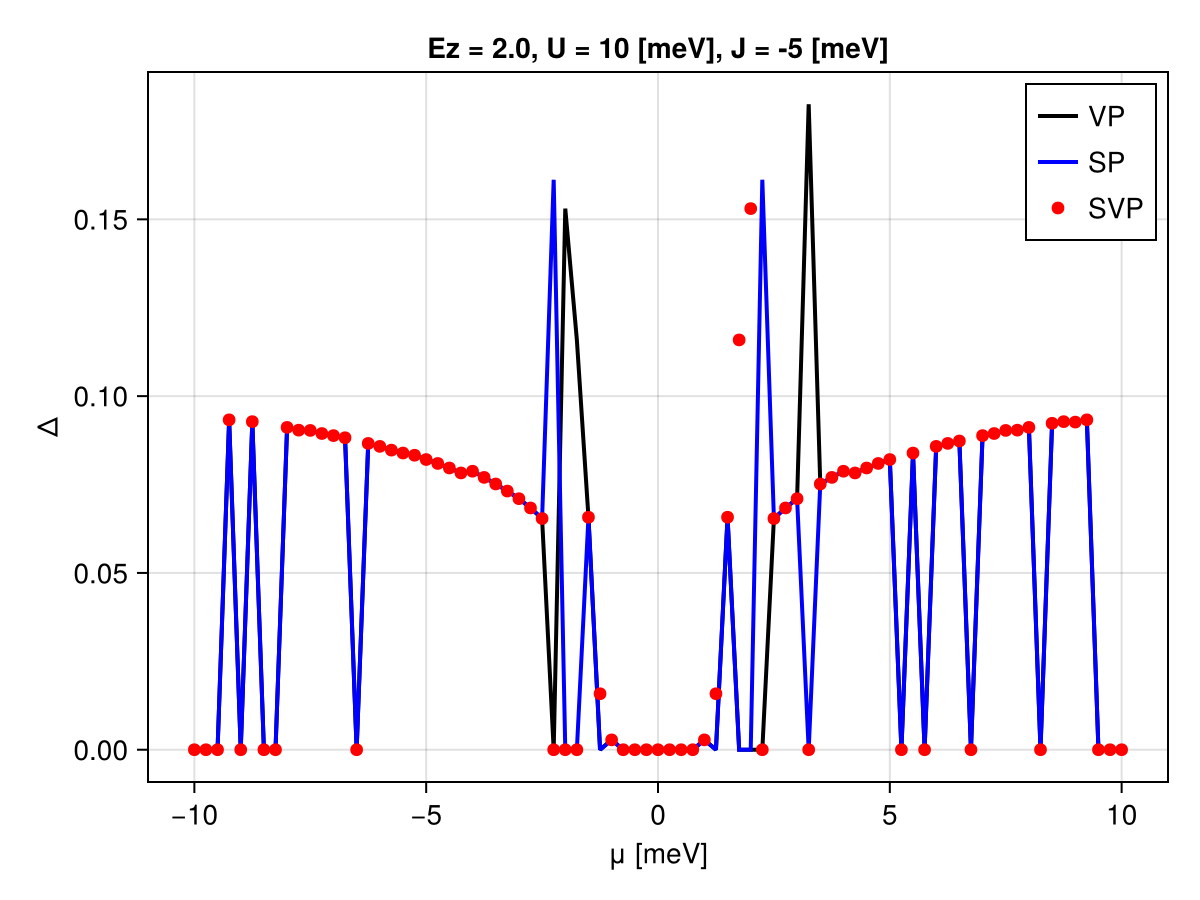

In [193]:
include(rhomb_folder * "local_hartree_optimization.jl")
fig = Figure(); ax = Axis(fig[1,1], xlabel = "μ [meV]", ylabel = "Δ", title = "Ez = $(p.Delta_Ez), U = $(U) [meV], J = $(J) [meV]")
lines!(ax, μlist, [polarization(nαs[i])[1] for i in 1:length(nαs)], label = "VP", color = "black", linewidth = 2)
lines!(ax, μlist, [polarization(nαs[i])[2] for i in 1:length(nαs)], label = "SP", color = :blue, linewidth = 2)
scatter!(ax, μlist, [polarization(nαs[i])[3] for i in 1:length(nαs)], label = "SVP", color = :red, linewidth = 2)
# ylims!(ax, [-0.1,2.1])
# scatter!(ax, μlist,[rh_order_parameter(nαs[i])[3] for i in 1:length(nαs)], label = "1-3", color = :purple, markersize = 6)
axislegend(ax)
fig

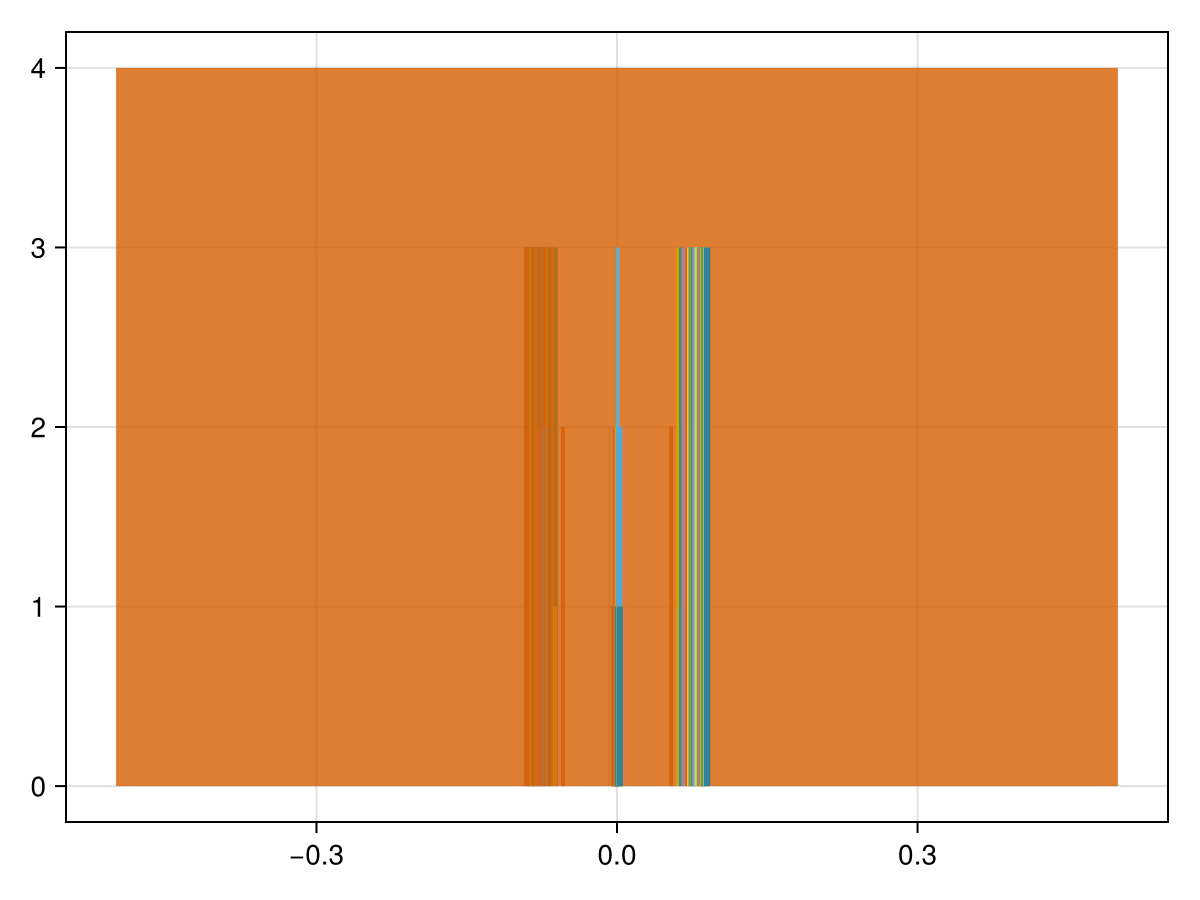

In [209]:
fig = Figure()
dim = length(nαs)
ax = Axis(fig[1,1])
for i in 1:dim
     hist!(ax, nαs[i])
end
fig

In [210]:
nαs[1]

4-element Vector{Float64}:
 -0.07984762405987866
 -0.07984762406083563
 -0.07984762405823821
 -0.07984762405893955

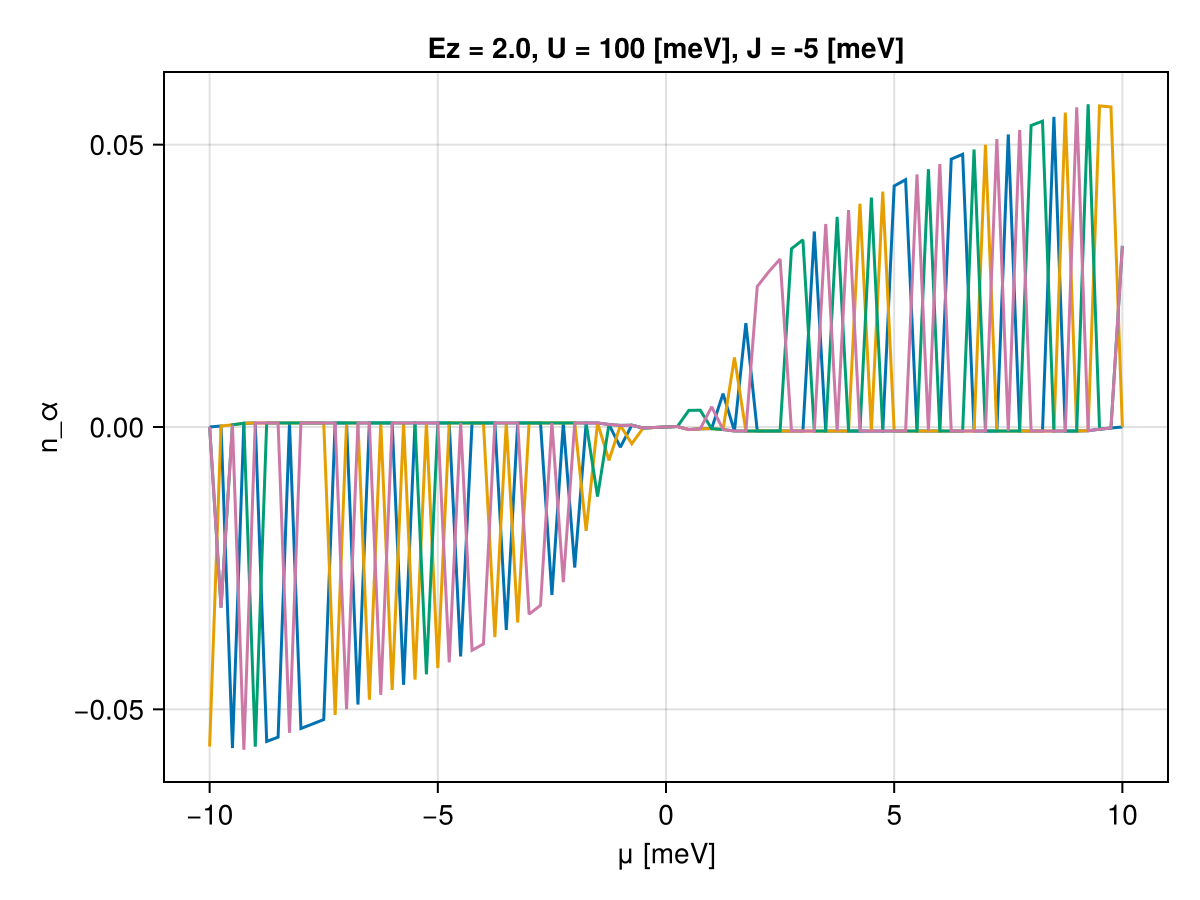

In [191]:
fig = Figure(); ax = Axis(fig[1,1], xlabel = "μ [meV]", ylabel = "n_α", title = "Ez = $(p.Delta_Ez), U = $(U) [meV], J = $(J) [meV]")
lines!(ax, μlist, [nαs[i][1] for i in 1:length(nαs)], label = "K↑")
lines!(ax, μlist, [nαs[i][2] for i in 1:length(nαs)], label = "K'↑")
lines!(ax, μlist,[nαs[i][3] for i in 1:length(nαs)], label = "K↓")
lines!(ax, μlist, [nαs[i][4] for i in 1:length(nαs)], label = "K'↓")
fig

In [47]:
ind = 49
println(nαs[ind])
polarization(nαs[ind])


[-0.05514671156056664, -0.05514671156060637, 0.05544728180334498, 0.05544728180334498]


(3.5919691188200456e-13, 1.9999926137079012, 3.5919691188200456e-13)

### Bands of the spinfull model with local Hartree

In [132]:
function spinfull_plotbandsanddos(N, p, nαs, μαs, Ez, μlist; points = 100, evals = 100, η = 0.05)

    ps =[Params_rhombohedral(p, μ = μαs[1], ξ = 1, Delta_Ez = Ez, Valley_asym = 0),
    Params_rhombohedral(p, μ = μαs[2], ξ = -1, Delta_Ez = Ez, Valley_asym = 0),
    Params_rhombohedral(p, μ = μαs[3], ξ = 1, Delta_Ez = Ez, Valley_asym = 0),
    Params_rhombohedral(p, μ = μαs[4], ξ = -1, Delta_Ez = Ez, Valley_asym = 0)]

    
    fig = Figure()
    ax = Axis(fig[1, 1]; xlabel = "kx", ylabel = "E [meV]", 
        title = "N = $(N), ν = $(round(sum(nαs),digits = 2)), Ez = $(Ez)")
    # spinfull_plotbands!(ax, N, p, μαs, Ez, points = points)
    
    
    abcNplotbandsk(ax, N, points, ps[1]; ylims = [-1, 1])#, style = :solid)
    abcNplotbandsk(ax, N, points, ps[2]; ylims = [-1, 1])#, style = :dash)
    abcNplotbandsk(ax, N, points, ps[3]; ylims = [-1, 1])#, style = :solid)
    abcNplotbandsk(ax, N, points, ps[4]; ylims = [-1, 1])#, style = :dash)
    
    ax2 = Axis(fig[1,2], xlabel = "μ [meV]", ylabel = "DOS (a.u.)", title = "ν = $(round(sum(nαs),digits = 2)), Ez = $(Ez)")
    ω, js = spinfull_dos(N, ps, η, evals, μlist)
    plot_dos!(ax2, ω, js)
    fig
end


function spinfull_plotbands(N, p, nαs, μαs, Ez; points = 100)
    fig = Figure()
    ax = Axis(fig[1:2, 0]; xlabel = "kx", ylabel = "E [meV]", title = "N = $(N), ν = $(round(sum(nαs),digits = 2)), Ez = $(Ez)")
    spinfull_plotbands!(ax, N, p, μαs, Ez, points = points)
    return fig
end
"""
Now 1 → K↑, 2 → K'↑, 3 → K↓, 4 → K'↓.
"""
function spinfull_plotbands!(ax, N, p, μαs, Ez; points = 100)
    ps =[Params_rhombohedral(p, μ = μαs[1], ξ = 1, Delta_Ez = Ez, Valley_asym = 0),
        Params_rhombohedral(p, μ = μαs[2], ξ = -1, Delta_Ez = Ez, Valley_asym = 0),
        Params_rhombohedral(p, μ = μαs[3], ξ = 1, Delta_Ez = Ez, Valley_asym = 0),
        Params_rhombohedral(p, μ = μαs[4], ξ = -1, Delta_Ez = Ez, Valley_asym = 0)]

    abcNplotbandsk(ax, N, points, ps[1]; ylims = [-1, 1])#, style = :solid)
    abcNplotbandsk(ax, N, points, ps[2]; ylims = [-1, 1])#, style = :dash)
    abcNplotbandsk(ax, N, points, ps[3]; ylims = [-1, 1])#, style = :solid)
    abcNplotbandsk(ax, N, points, ps[4]; ylims = [-1, 1])#, style = :dash)
end

# function spinfull_dos(N, p, ns, μαs, Ez; evals = 100, η = 0.05)

#     ps =[Params_rhombohedral(p, μ = μαs[1], ξ = 1, Delta_Ez = Ez, Valley_asym = 0),
#         Params_rhombohedral(p, μ = μαs[2], ξ = -1, Delta_Ez = Ez, Valley_asym = 0),
#         Params_rhombohedral(p, μ = μαs[3], ξ = 1, Delta_Ez = Ez, Valley_asym = 0),
#         Params_rhombohedral(p, μ = μαs[4], ξ = -1, Delta_Ez = Ez, Valley_asym = 0)]

#     ω, js = spinfull_dos(N, ps, η, evals)
#     fig = Figure()
#     ax = Axis(fig[1,1], xlabel = "μ [meV]", ylabel = "DOS (a.u.)", title = "ν = $(round(sum(ns),digits = 2)), Ez = $(Ez)")
#     plot_dos!(ax, ω, js)
#     fig
# end

function spinfull_dos(N, ps, η, evals, μlist)
    nps = [xxx_lmc_presets(N, ps[i]) for i in 1:length(ps)]
    ω, j1 = c_dos(nps[1], μlist, η = η, evals = evals)
    ω, j2 = c_dos(nps[2], μlist, η = η, evals = evals)
    ω, j3 = c_dos(nps[3], μlist, η = η, evals = evals)
    ω, j4 = c_dos(nps[4], μlist, η = η, evals = evals)
    return ω, [j1,j2,j3,j4]
end

function plot_dos!(ax, ω, js)
    colors = [:black, :black, :gray, :gray]
    styles = [:solid, :dash, :solid, :dash]
    labels = ["K↑", "K'↑", "K↓","K'↓"]
    for (i,j) in enumerate(js)
        lines!(ax, ω, j, color = colors[i], linestyle = styles[i], label = labels[i])
    end
    axislegend(ax)
end

plot_dos! (generic function with 1 method)

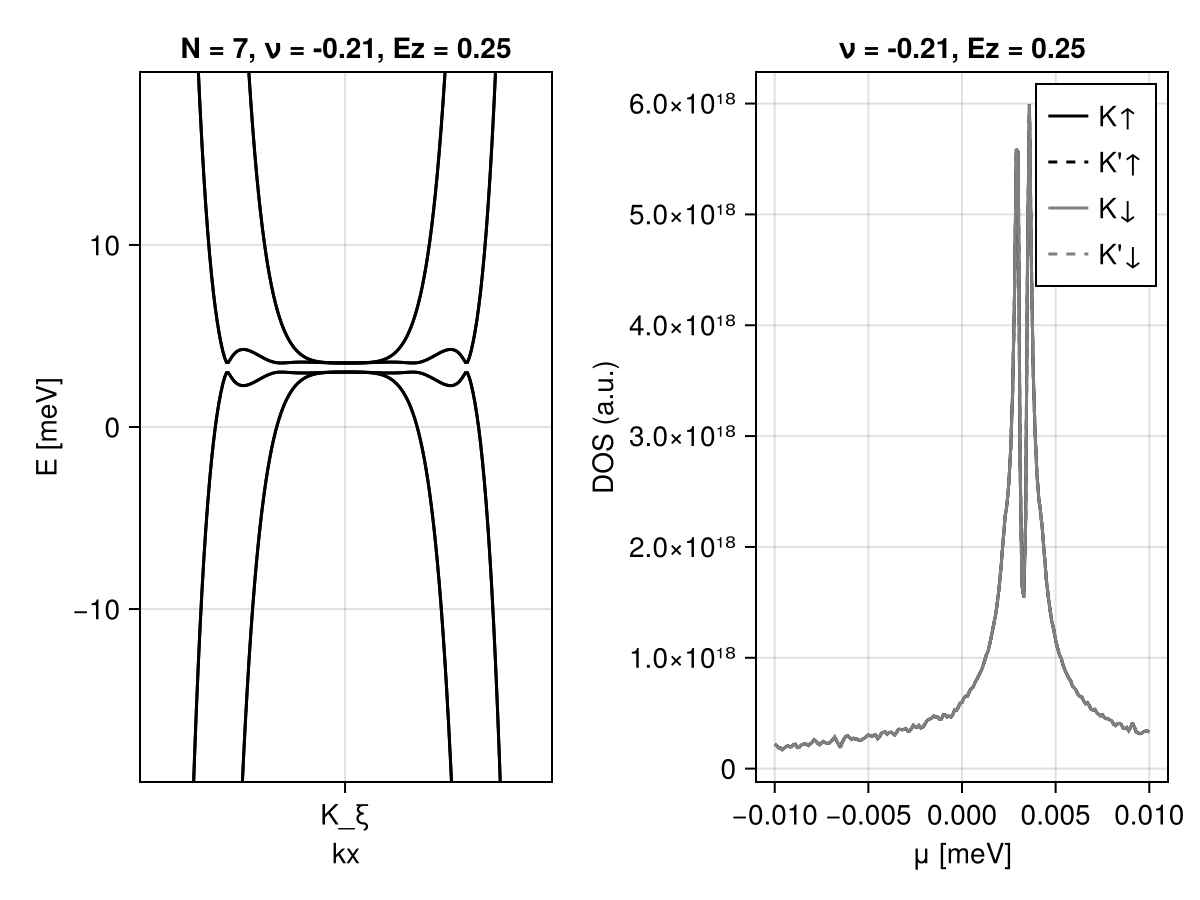

In [135]:
# 10 seconds
Ez_ind = 2 
μ_ind = 2 #
spinfull_plotbandsanddos(N, p, ns[Ez_ind][μ_ind], μs[Ez_ind][μ_ind], Ezlist[Ez_ind], collect(-10:0.1:10); points = 100, evals = 2e4, η = 0.1)

In [ ]:
# spinfull_dos(N, p, ns[Ez_ind][μ_ind], μs[Ez_ind][μ_ind], 3*Ezlist[Ez_ind]; evals = 1e3, η = 0.05)

In [113]:
Ez_ind = 15
μ_ind = 2

spinfull_plotbands(N, p, ns[Ez_ind][μ_ind], μs[Ez_ind][μ_ind], Ezlist[Ez_ind] ; points = 100)

ErrorException: type Int64 has no field γ1

## Optical observables

In [259]:
#_________________________________________________________________________________________
# LMC
#_________________________________________________________________________________________
"""
function observable functions are defined for each flavour so you have to sum
the four of them to get the experimental value
"""
function lmc_map(N, p::Params_rhombohedral, Ezlist, νlist, μαs; kws...)
    presets(; ξ, Ez, μ) = xxx_lmc_presets(N, 
        Params_rhombohedral(p, ξ = ξ, μ = μ, Delta_Ez = Ez); kws...)
    return map_eval(linear_magneto_conductivity_orbital, presets, μαs, Ezlist, νlist)
end

plot_lmc(N, U, J, Ezlist, νlist, mat; kws...) = 
    plot_mat(N, U, J, Ezlist, νlist, mat, "LMC", "σxxx [1/T*e²/h]"; kws...)
#_______________________________________________________________________________________
# Drude
#_________________________________________________________________________________________
function drude_map(N, p::Params_rhombohedral, Ezlist, νlist, μαs; kws...)
    presets(; ξ, Ez, μ) = 
        xx_drude_presets(N, Params_rhombohedral(p, ξ = ξ, μ = μ, Delta_Ez = Ez); kws...)
        return map_eval(drude_conductivity, presets, μαs, Ezlist, νlist)
end

plot_drude(N, U, J, Ezlist, νlist, mat; kws...) = 
    plot_mat(N, U, J, Ezlist, νlist, mat, "σxx", "σxx [e²/h]"; kws...)
#_________________________________________________________________________________________
# AHE. xy
#_________________________________________________________________________________________
function ahe_map(N, p::Params_rhombohedral, Ezlist, νlist, μαs; kws...)
    presets(; ξ, Ez, μ) = 
        qah_presets(N, :x, :y, Params_rhombohedral(p, ξ = ξ, μ = μ, Delta_Ez = Ez); kws...)
    return map_eval(σij_anomalous_hall, presets, μαs, Ezlist, νlist)
end

plot_ahe(N, U, J, Ezlist, νlist, mat; kws...) = 
    plot_mat(N, U, J, Ezlist, νlist, mat, "AHE", "σxy [e²/h]"; kws...)

#_________________________________________________________________________________________
# Evaluator
#_________________________________________________________________________________________
function map_eval(obs, presets, μαs, Ezlist, νlist)
    μs = reshape_densities(μαs)
    dimx = size(μs[1],1)
    dimy = size(μs[1],2)
    ξs = [1, -1, 1, -1] # valley array
    mat = zeros(Float64, dimx, dimy)
    for (i,Ez) in enumerate(Ezlist)
        for (j, ν) in enumerate(νlist)
            mat[i,j] = sum([obs(presets(ξ = ξs[k], Ez = Ez, μ = μs[k][i,j])) for k in 1:4]) # sum over the 4 flavors
            # mat[i,j] = obs(presets(ξ = ξs[1], Ez = Ez, μ = μs[1][i,j])) # single flavour
        end
    end
    return mat
end
#_________________________________________________________________________________________
# Plotter
#_________________________________________________________________________________________
function plot_mat(N, U, J, Ezlist, νlist, matt, label, labellegend; colorrange = [-maximum(abs.(matt)), maximum(abs.(matt))])
    fig = Figure()
    ax= Axis(fig[1,1], xlabel = "Ez [meV]", ylabel = "ν", title = "$(label): N = $(N), U = $(U), J = $(J)")
    ylims!(ax,  νlist[1], νlist[end])
    xlims!(ax, Ezlist[1], Ezlist[end])
    colors = cgrad([:lightblue,:black,:red])
    # hm =  heatmap!(ax, Ezlist,  νlist, mat, colormap = colors, colorrange = [-maximum(mat), maximum(mat)])#, colorrange = [-1,2])#, rasterize = true)
    hm =  heatmap!(ax, Ezlist,  νlist, matt, colormap = colors, colorrange = colorrange)#, colorrange = [-1,2])#, rasterize = true)

    cb = Colorbar(fig[1,2], hm, label = labellegend)
    return fig
end




plot_mat (generic function with 2 methods)

In [260]:
drudes = drude_map(N, p, Ezlist, νlist, μs, evals = 200, T = 2);

In [261]:
lmcs = lmc_map(N, p, Ezlist, νlist, μs, evals = 200, T = 2);

In [262]:
qahs = ahe_map(N, p, Ezlist, νlist, μs, evals = 200, T = 2);

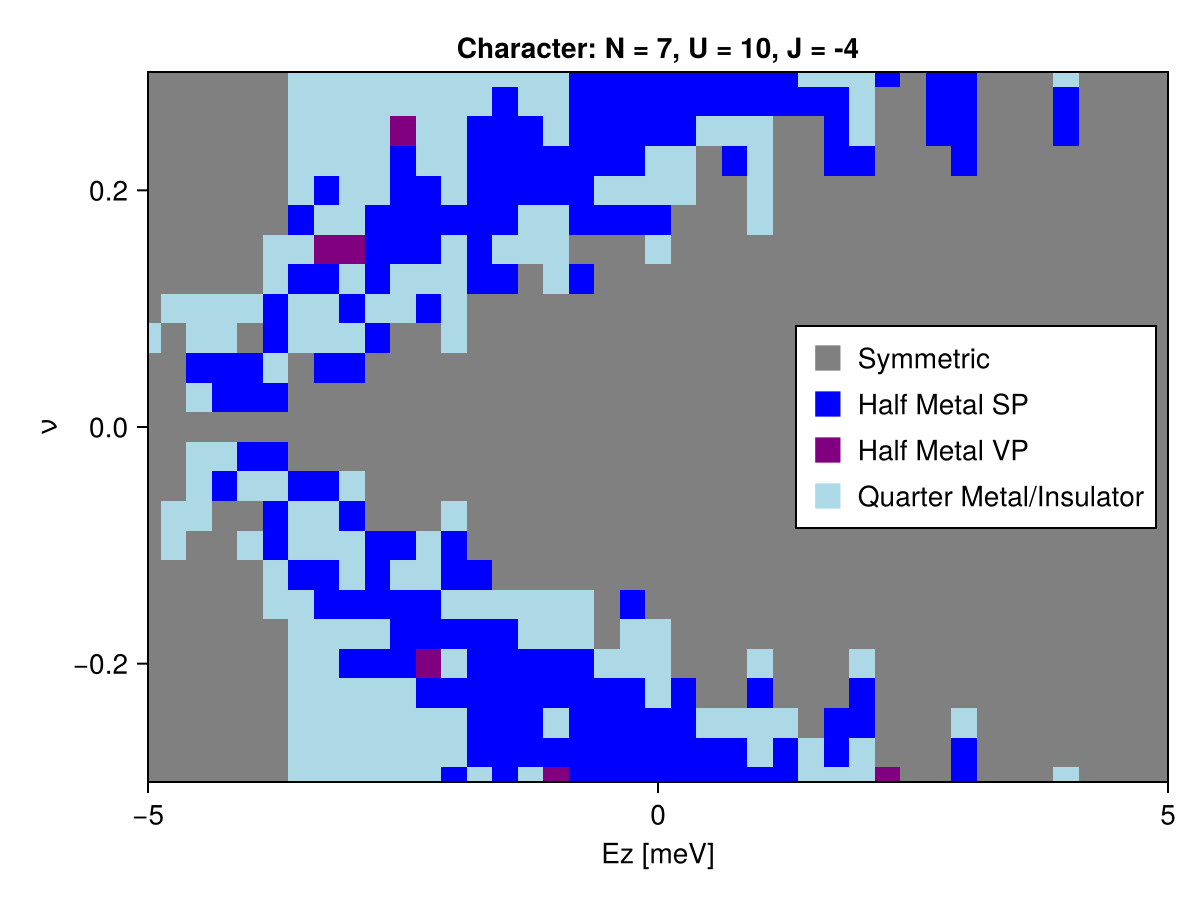

In [263]:
plot_characters(N, U, J, Ezlist, νlist, ns)

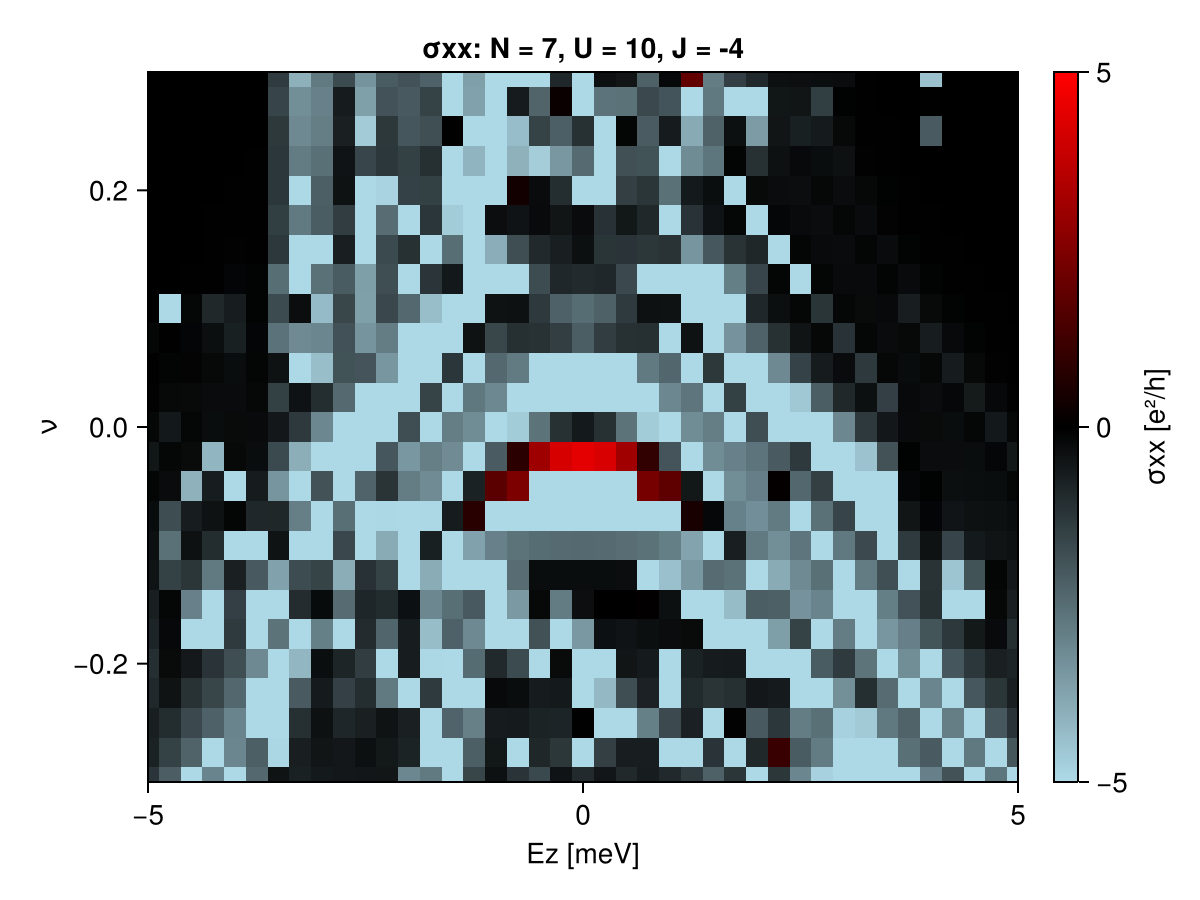

In [264]:
plot_drude(N, U, J, Ezlist, νlist, drudes, colorrange = [-5,5])

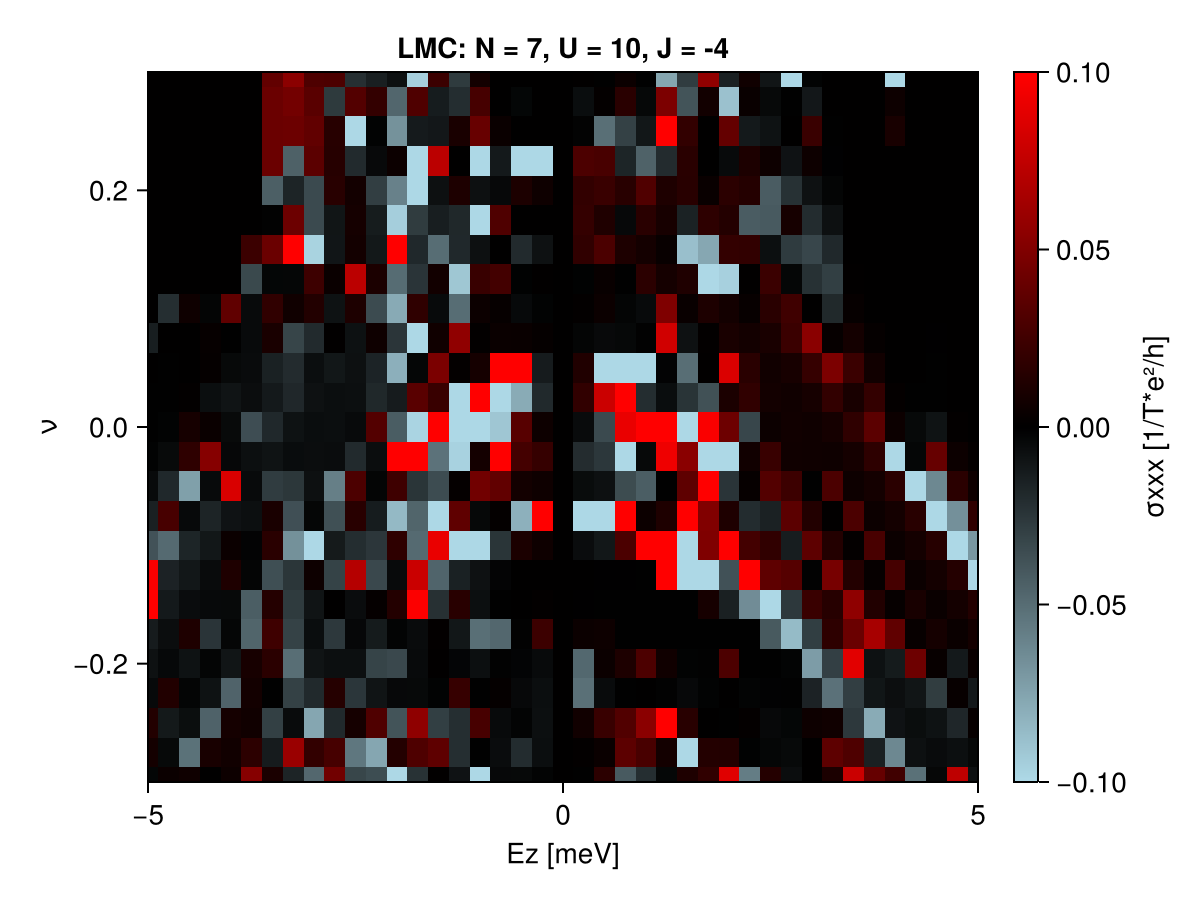

In [265]:
plot_lmc(N, U, J, Ezlist, νlist, lmcs, colorrange = [-0.1,0.1])

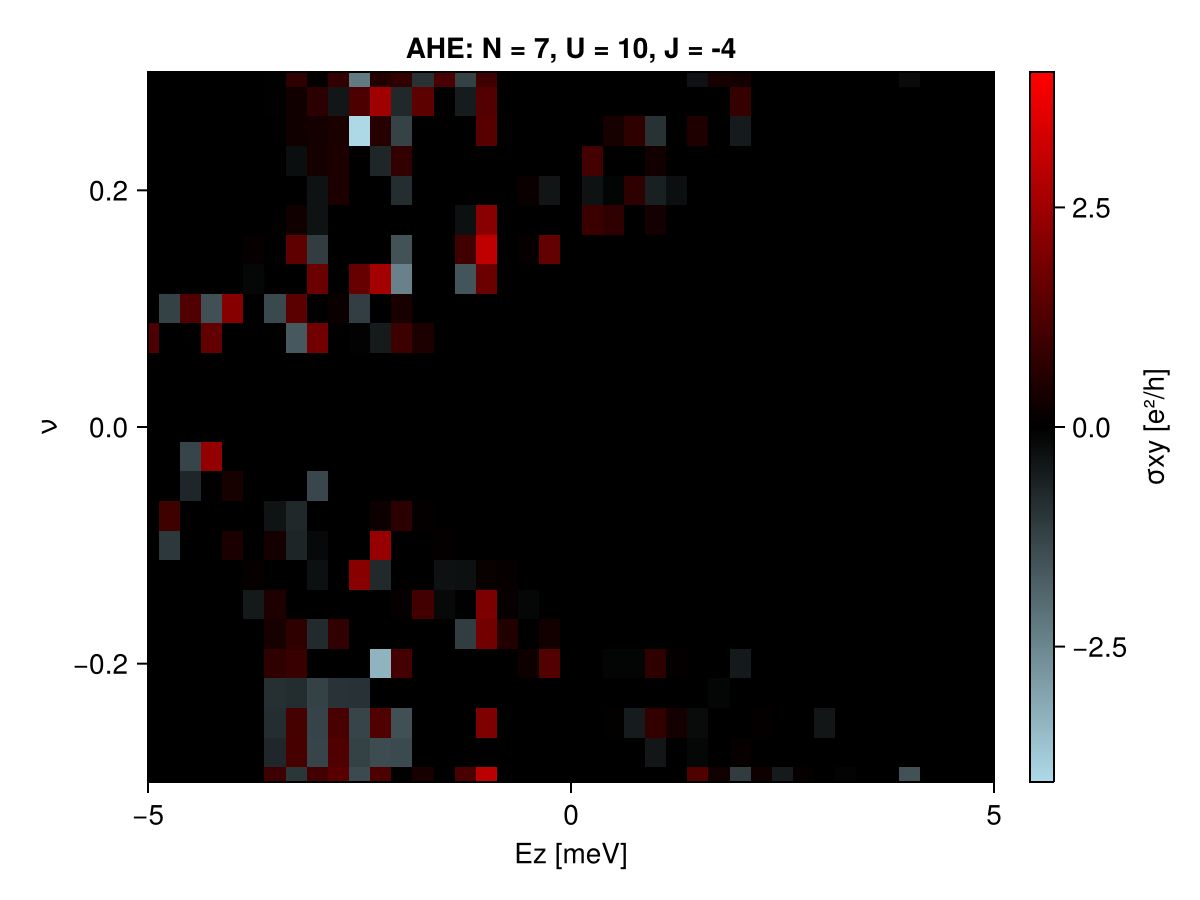

In [266]:
plot_ahe(N, U, J, Ezlist, νlist, qahs)

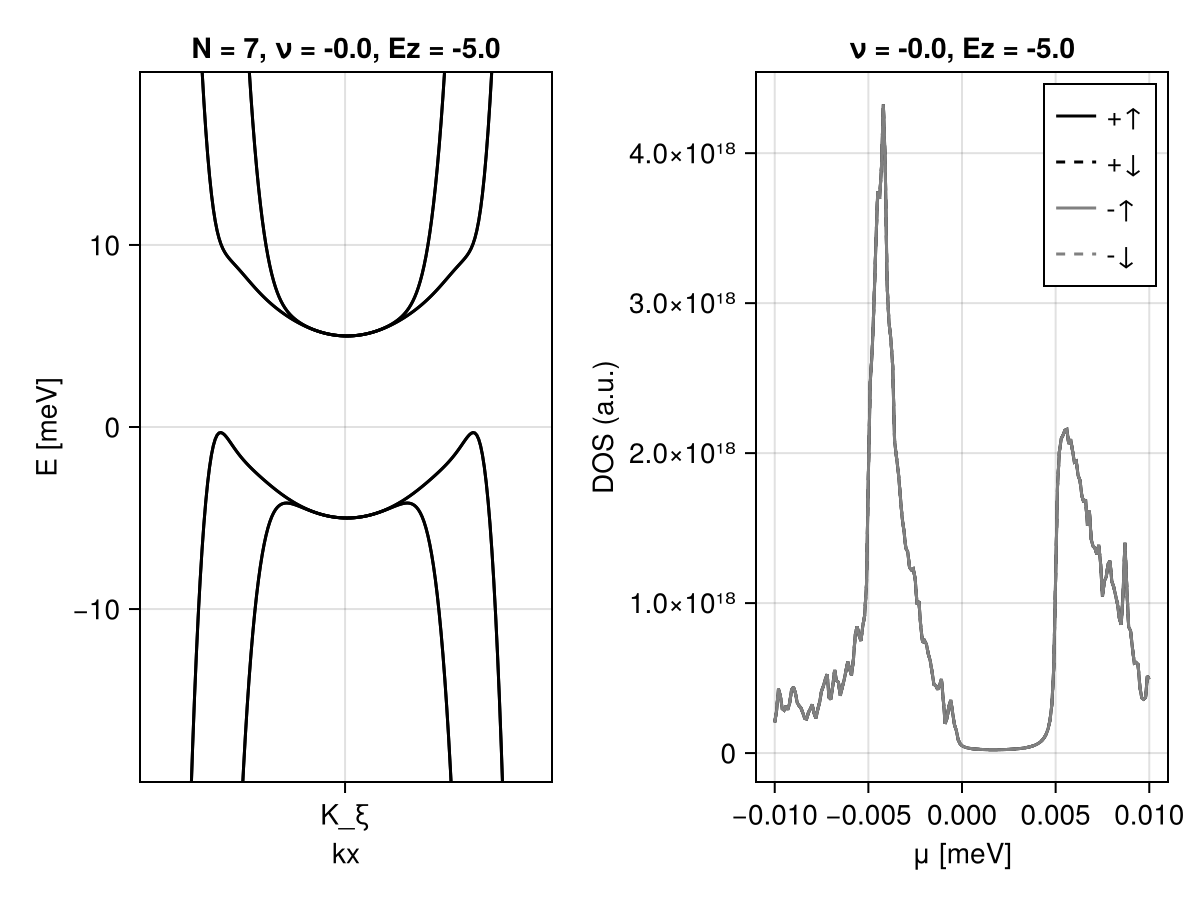

In [315]:
# 10 seconds
Ez_ind = 1
μ_ind = 4 #
spinfull_plotbandsanddos(N, p, ns[Ez_ind][μ_ind], μs[Ez_ind][μ_ind], Ezlist[Ez_ind], collect(-10:0.1:10); points = 100, evals = 5e3, η = 0.1)